# Spectroscopic factors

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ October 8, 2021

This notebook serves as a testbed for calculating spectroscopic overlaps using mean field approximations for initial and final states and applying SRG transformations to the operator. The normalization of spectroscopic overlaps give relative spectroscopic factors. The first step is to compute the overlap of $^4\rm{He}$ with $^3\rm{H}$ and compare to [VMC calculations](https://www.phy.anl.gov/theory/research/overlaps/).

_Last update:_ August 30, 2022

__To-do list:__
* Tidy this notebook up and add to this list.
* Add description of notebook.

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.special import spherical_jn

In [2]:
# Imports from A.T. codes
from scripts.figures import set_rc_parameters, label_nucleus, label_sp_state
from scripts.integration import momentum_mesh
from scripts.tools import replace_periods

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/spectroscopic_factors/'

# Load s.p. wave functions from the following directory
hfbrad_directory = '../data/dft/SLy4/'

## Functions

Move some of these functions into scripts at a later date.

In [5]:
def convert_l_to_string(l):
    """
    Returns the spectroscopic notation of the orbital angular momentum value
    l (e.g., l = 2 returns 'd').

    Parameters
    ----------
    l : int
        Orbital angular momentum of the single-particle (s.p.) state.

    Returns
    -------
    l_str : str
        Spectroscopic notation of s.p. state orbital angular momentum.

    """

    if l == 0:
        return 's'
    elif l == 1:
        return 'p'
    elif l == 2:
        return 'd'
    elif l == 3:
        return 'f'
    elif l == 4:
        return 'g'
    elif l == 5:
        return 'h'
    elif l == 6:
        return 'i'
    else:
        raise RuntimeError(
            "Input l value is outside the range of this function."
        )

In [6]:
def sp_states(nucleus_name, Z, N, print_info=False):
    """
    Return all the occupied single-particle states of the given nucleus.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'Ca40').
    Z : int
        Proton number.
    N : int
        Neutron number.
    print_statement : bool, optional
        Option to print information for each s.p. state in nucleus.
    
    Returns
    -------
    output : dict
        Dictionary with two keys: 'proton' and 'neutron'. Each corresponds to
        a list of all the occupied s.p. states, which are strings (e.g., '1s0p5'
        means 1s with j=1/2).
    
    Notes
    -----
    Currently we're assuming the SLy4 interaction.
    
    """

    # Go to HFBRAD directory
    densities_directory = f'../data/dft/SLy4/{nucleus_name}/'
    file_name = f'hfb_{N}_{Z}.spe'
    
    # Open file and add each occupied s.p. state to list
    neutron_states = []
    proton_states = []
    
    f = open(densities_directory + file_name, 'r')
    
    for line in f:
        
        unit = line.strip().split()  # Split up row into list
        
        # Make sure you're going through the correct data
        if (len(unit) == 12) and (unit[0] in ('1', '2')):
            
            # Only do occupied states:
            if float(unit[6]) == 1:
            
                # Integer specifying neutron or proton
                nucleon_number = unit[0]
        
                # j value
                j = int(unit[1])/2
        
                # Orbital angular momentum (int)
                l = int(unit[2])
                # Orbital angular momentum (str)
                l_str = convert_l_to_string(l)
        
                # Is this correct? (# of nodes)
                n = unit[11]
            
                # Convert s.p. state to string and append to list
                state_str = f'{n}{l_str}{j:.1f}'
            
                # Add string to neutron or proton list with periods replaced
                # by 'p'
                if nucleon_number == '1': # Neutron
                    neutron_states.append(replace_periods(state_str))
                elif nucleon_number == '2': # Proton
                    proton_states.append(replace_periods(state_str))
            
                # Print information for each state?
                if print_info:
                
                    info = (f"Nuc={nucleon_number}, N={unit[4]},"
                            f" state={state_str}")
                    print(info)
                
    f.close()
    
    return {'neutron' : neutron_states, 'proton' : proton_states}

In [7]:
def get_phi_rspace(
        nucleus_name, Z, N, nucleon, sp_state, density='SLy4',
        print_normalization=False):
    """Returns the single-particle wave function in coordinate space."""
    
    if nucleon == 'proton':
        nuc_int = 1
    elif nucleon == 'neutron':
        nuc_int = 0
    
    file_name = f'{nucleon}_{sp_state}_{N}_{Z}.gfx'
    
    data = np.loadtxt(hfbrad_directory + f"{nucleus_name}/wfs/{file_name}")

    r_array = data[:, 0]  # Units fm
    dr = r_array[1] - r_array[0]  # Linear spacing between r points
    phi_array = data[:, 2]  # Units fm^-1/2
    
    # Print the normalization?
    # These are normalization as \int dr |\phi(r)|^2 = 1
    if print_normalization:
        print(np.sum(dr*phi_array**2))
    
    return r_array, phi_array

In [8]:
def plot_sp_wfs_rspace(
        nucleus_name, Z, N, density='SLy4', x_limits=(0.0,10.0),
        y_limits=(0.0,0.8), save=False):
    """Plot the s.p. wave functions of a nucleus in coordinate space."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Get the data
    d = sp_states(nucleus_name, Z, N)
    
    # Plot just the proton wave functions
    for i, sp_state in enumerate(d['proton']):
        
        r_array, phi_array = get_phi_rspace(nucleus_name, Z, N, 'proton',
                                            sp_state, density)
        
        ax.plot(r_array, phi_array, label=label_sp_state(sp_state),
                linewidth=2.0)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$r$ [fm]", fontsize=16)
    ax.set_ylabel(r"$\phi(r)$ [fm" + r'$^{-1/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_rspace_{density}.png'
        f.savefig(figures_directory + file_name)

In [9]:
def hankel_transformation(l, k_array, r_array, dr):
    """
    <k|r> transformation matrix for given orbital angular momentum l. If
    len(r_array) = m and len(k_array) = n, then this function returns an 
    n x m matrix.
    
    Parameters
    ----------
    l : int
        Orbital angular momentum.
    k_array : 1-D ndarray
        Momentum array [fm^-1].
    r_array : 1-D ndarray
        Coordinates array [fm].
    dr : float
        Coordinates step-size (weight) [fm].
        
    Returns
    -------
    M : 2-D ndarray
        Hankel transformation matrix [fm^3\2].
        
    Notes
    -----
    There is a "missing" factor of r in the transformation matrix since the
    \phi(r) wave functions are already multiplied by r, meaning the
    normalization is \int dr |\phi(r)|^2 = 1 without the r^2.

    """

    # r_array column vectors and k_array row vectors where both grids are
    # n x m matrices
    r_cols, k_rows = np.meshgrid(r_array, k_array)
        
    M = dr * r_cols * spherical_jn(l, k_rows * r_cols)

    return M

In [10]:
def convert_l_to_int(sp_state):
    """Convert string representation of l to its integer value."""
    
    if sp_state[1] == 's':
        l = 0
    elif sp_state[1] == 'p':
        l = 1       
    elif sp_state[1] == 'd':
        l = 2
    elif sp_state[1] == 'f':
        l = 3
    else:
        raise RuntimeError("The l value is beyond the limits of this function.")
        
    return l

In [11]:
def get_phi_kspace(
        nucleus_name, Z, N, nucleon, sp_state, density='SLy4',
        print_normalization=False):
    """Returns the single-particle wave function in momentum space."""
    
    # Set momentum mesh
    k_array, k_weights = momentum_mesh(15.0, 3.0, 120)
    
    # Get coordinate-space s.p. wave function
    r_array, phi_r_array = get_phi_rspace(nucleus_name, Z, N, nucleon, sp_state,
                                          density)
    dr = r_array[2] - r_array[1]  # Assuming linear spacing in coordinates
    
    # Fourier-transform the wave function to momentum space
    l = convert_l_to_int(sp_state)
    phi_k_array = hankel_transformation(l, k_array, r_array, dr) @ phi_r_array
    
    # Print the normalization?
    # These are normalization as 2/\pi \int dk k^2 |\phi(k)|^2 = 1
    if print_normalization:
        print(2/np.pi*np.sum(k_weights*k_array**2*phi_k_array**2))

    return k_array, phi_k_array

In [12]:
def plot_sp_wfs_kspace(
        nucleus_name, Z, N, density='SLy4', x_limits=(0.0,5.0),
        y_limits=(0.0,5.0), save=False):
    """Plot the s.p. wave functions of a nucleus in momentum space."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Get the data
    d = sp_states(nucleus_name, Z, N)
    
    # Plot just the proton wave functions
    for i, sp_state in enumerate(d['proton']):
        
        k_array, phi_array = get_phi_kspace(nucleus_name, Z, N, 'proton',
                                            sp_state, density)
        
        ax.plot(k_array, phi_array, label=label_sp_state(sp_state),
                linewidth=2.0)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$k$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$\phi(k)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_kspace_{density}.png'
        f.savefig(figures_directory + file_name)

## Single-particle wave functions in coordinate space

In [13]:
nucleus_name, Z, N = 'He4', 2, 2

In [14]:
sp_states(nucleus_name, Z, N, print_info=True)

Nuc=1, N=1, state=1s0.5
Nuc=2, N=154, state=1s0.5


{'neutron': ['1s0p5'], 'proton': ['1s0p5']}

In [15]:
phi_r_array = get_phi_rspace(nucleus_name, Z, N, 'proton', '1s0p5',
                             print_normalization=True)

1.0000000007365384


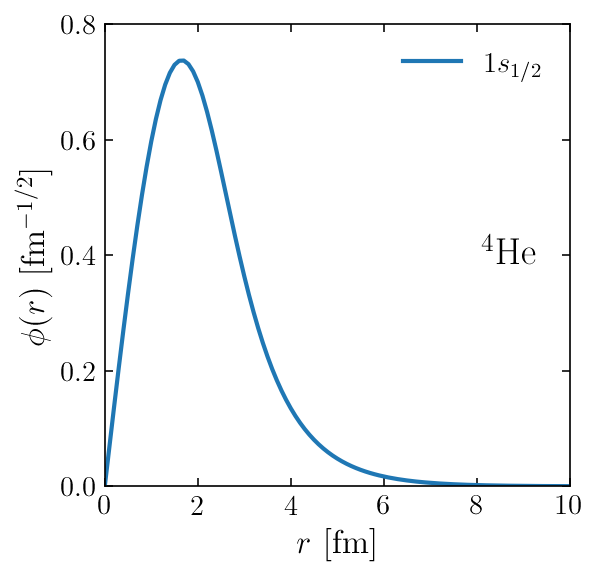

In [16]:
plot_sp_wfs_rspace(nucleus_name, Z, N, save=True)

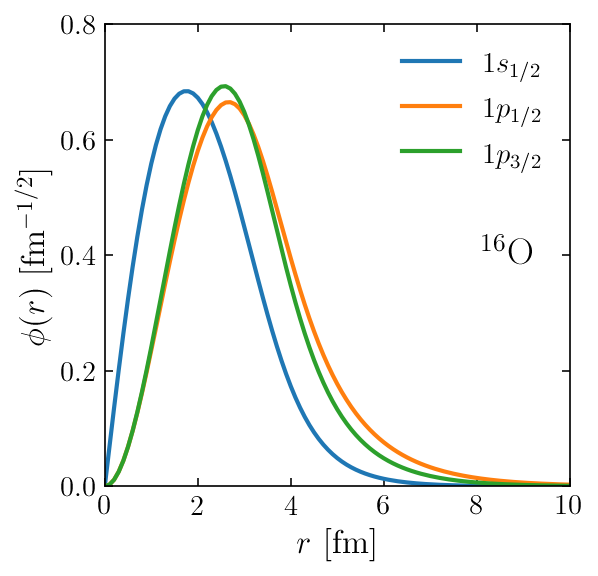

In [17]:
plot_sp_wfs_rspace('O16', 8, 8, save=True)

## Single-particle wave functions in momentum space

In [18]:
phi_k_array = get_phi_kspace(nucleus_name, Z, N, 'proton', '1s0p5',
                             print_normalization=True)

1.0000000007365952


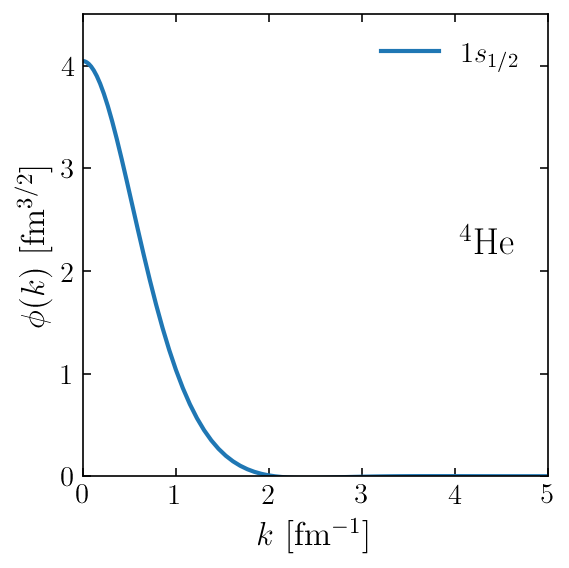

In [19]:
plot_sp_wfs_kspace(nucleus_name, Z, N, y_limits=(0.0,4.5), save=True)

## Momentum distributions

_Old stuff_

NameError: name 'ntot' is not defined

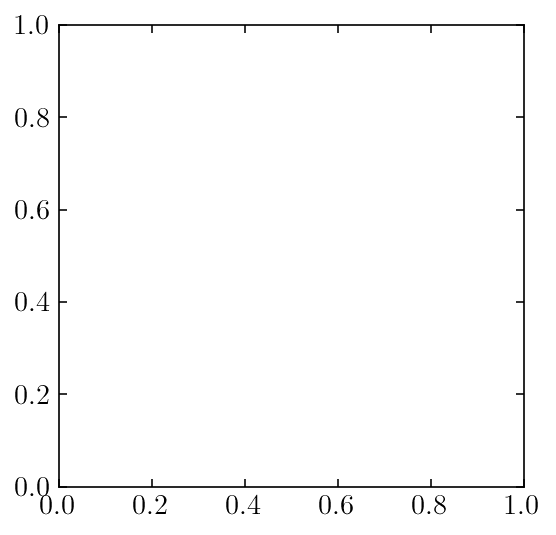

In [20]:
# Test momentum distribution assuming IPM
from scripts.momentum_distributions import MomentumDistribution

# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'p [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = r'$n^A(p)$/Z' + ' [fm' + r'$^{3}$' + ']'
y_label_size = 16

xlim = (0.0, 6.0) # fm^-1
ylim = (4e-3, 2e2)

# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

n_array = np.zeros(ntot)
for i, state in enumerate(selected_states):

    phi_data = d[nucleon][state]
    r_array = phi_data[:, 0]
    dr = r_array[1] - r_array[0]
    phi_r_array = phi_data[:, 2]
        
    # Transform to momentum space
    if state[1] == 's':
        l = 0
    elif state[1] == 'p':
        l = 1
    elif state[1] == 'd':
        l = 2
    elif state[1] == 'f':
        l = 3
    ft_matrix = hankel_transformation(l, p_array, r_array, dr)
    phi_p_array = ft_matrix @ phi_r_array
    
    j = int(state[-3]) + 1/2
    print(j)
    n_array += (2*j+1)*abs(phi_p_array)**2
    
# Set y-axis to log scale
ax.set_yscale('log')

# Plot with respect to energy
# fac = (2*np.pi)**3
fac = 2/np.pi*(2*np.pi)**3/(4*np.pi)
ax.plot(p_array, fac*n_array/Z, color='xkcd:blue', linewidth=curve_width,
        label=r'$\sum_{\alpha} |\phi_{\alpha}(p)|^2$')

# Print out normalizations
norm_n = 2/np.pi*np.sum(p_weights*p_array**2*n_array/Z)
print(f'Normalization of n^A(p) = {norm_n:.5f}')

# --- Overlay previous results --- #
md = MomentumDistribution(kvnn, kmax, kmid, ntot)
edf = 'SLy4'
q_array, n_p_array = md.get_single_nucleon_momentum_distribution(
    'proton', nucleus_name, edf, channels, 'Wegner', lamb)
n_p_array *= 1/Z

# Momentum distributions from VMC calculations
vmc_data_directory = '../data/vmc/momentum_distributions/'

# Add curve to figure
ax.plot(q_array, n_p_array, color='xkcd:red', label='HF+LDA', linewidth=curve_width)
        
# Add AV18 data with error bars
av18_data = np.loadtxt(vmc_data_directory + f'{nucleus_name}_single_nucleon.txt')
q_array_av18 = av18_data[:, 0] # fm^-1
n_p_array_av18 = av18_data[:, 1] / Z
error_bars_array_av18 = av18_data[:, 2] / Z

# Print normalization
dq = q_array_av18[2]-q_array_av18[1]
norm_av18 = 4*np.pi/(2*np.pi)**3*np.sum(dq*q_array_av18**2*n_p_array_av18)
print(f'Normalization of n^A_AV18(p) = {norm_av18:.5f}')
            
# AV18 data with error bars
ax.errorbar(q_array_av18, n_p_array_av18, yerr=error_bars_array_av18, color='xkcd:black', label='AV18',
            linestyle='', marker='.')
# ------ #
        
# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Set legend
legend_size = 14
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Add nucleus label
nucleus_label = label_nucleus(nucleus_name)
nucleus_label_location = 'lower left'
nucleus_label_size = 18
anchored_text = AnchoredText(nucleus_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
                             frameon=False)
ax.add_artist(anchored_text);

# Spectroscopic factors

Definition of spectroscopic factor for a particular state $\alpha$ from Dickhoff (7.6):

</br>
<div align="center">
$S_{\alpha} = \int d\mathbf{p} \lvert \langle \Psi_{\alpha}^{A-1} \lvert a_{\mathbf{p}} \rvert \Psi_0^A \rangle \rvert^2$.
</div>


If we SRG-evolve the matrix element, and truncate the evolved operator to 2-body level, we arrive at the following:

</br>
<div align="left">
$S_{\alpha}(\lambda) = \int d\mathbf{p} \lvert \phi_{\alpha}(p) \rvert^2
\Bigl| 4\pi \int_0^{\infty} dR R^2 \theta(k_{\rm F}^{\tau}(R)-p)$
    </br>$\quad\quad\times\,
    \Bigl[ 2 + 16 \sum_{L,S,T}' \sum_{J} (2J+1) \frac{2}{\pi} \int_0^{\infty} dk k^2
                (k (L S) J T \lvert \delta U^{\dagger} \rvert k (L S) J T)
                \sum_{\tau'} \lvert \langle \tau \tau'| T \, \tau+\tau' \rangle \rvert^2
                \int_{-1}^1 \frac{dx}{2}
                \theta( k_{\rm F}^{\tau'}(R) - \lvert \mathbf{p}-2\mathbf{k} \rvert )
    \Bigr]
    \Bigr|^2$
</div>
    
_Last updated: Oct 21_

In [ ]:
# Oct 21 version
class spectroscopic_factor_v1(object):
    
    
    def __init__(self, kvnn, channels, lamb, kmax, kmid, ntot, generator='Wegner'):
        """
        Evaluates and saves the pp and pn matrix elements of \delta U^{\dagger} given
        the input potential and SRG \lambda.
        
        Parameters
        ----------
        kvnn : int
            This number specifies the potential.
        channels : tuple
            Partial wave channels to include in the calculation.
        lamb : float
            SRG evolution parameter lambda [fm^-1].
        kmax : float
            Maximum value in the momentum mesh [fm^-1]. (Default of zero
            automatically selects default mesh based on kvnn.)
        kmid : float
            Mid-point value in the momentum mesh [fm^-1].
        ntot : int
            Number of momentum points in mesh.
        generator : str, optional
            SRG generator 'Wegner', 'T', or 'Block-diag'.
            
        """
        
        # Get relevant info for file and directory names
        # Part of data directory name
        self.kvnn = kvnn 
        # Part of file name
        self.channels = channels
        self.lamb = lamb
        self.kmax = kmax
        self.generator = generator
        
        # Save highest allowed L based on input channels
        highest_L = 0
        for channel in channels:
            next_L = channel_L_value(channel)
            if next_L > highest_L:
                highest_L = next_L

        # Load and save momentum arrays
        potential_temp = Potential(kvnn, '1S0', kmax, kmid, ntot)
        k_array, k_weights = potential_temp.load_mesh()
            
        # For dividing out momenta/weights
        factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
        # For coupled-channel matrices
        factor_array_cc = np.concatenate( (factor_array, factor_array) )

        # Initialize pp and pn matrix elements
        deltaU_pp = np.zeros( (ntot, ntot) ) # \delta U linear term
        deltaU_pn = np.zeros( (ntot, ntot) )
        
        # Allowed channels for pp (and nn) up through the D-waves
        pp_channels = ('1S0', '3P0', '3P1', '3P2', '1D2')
        
        # Loop over channels and evaluate matrix elements
        for channel in channels:
            
            # Set potential
            potential = Potential(kvnn, channel, kmax, kmid, ntot)

            # Load SRG transformation
            H_initial = potential.load_hamiltonian()
            if generator == 'Block-diag':
                # Take \lambda = 1 fm^-1 and set \Lambda_BD = input \lambda
                H_evolved = potential.load_hamiltonian('srg', generator, 1.0,
                                                       lamb)
            else:
                H_evolved = potential.load_hamiltonian('srg', generator, lamb)
            # Load U(k, k') [unitless]
            U_matrix_unitless = get_transformation(H_initial, H_evolved)

            # Isolate 2-body term and convert to fm^3
            if coupled_channel(channel):
                I_matrix_unitless = np.eye( 2*ntot, 2*ntot )
                row, col = np.meshgrid(factor_array_cc, factor_array_cc)
            else:
                I_matrix_unitless = np.eye(ntot, ntot)
                row, col = np.meshgrid(factor_array, factor_array)
            delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
            delta_U_matrix = delta_U_matrix_unitless / row / col # fm^3
            
            # 2J+1 factor
            J = int( channel[-1] )
            
            # Add to the pp and pn terms
            # Coupled-channel
            if coupled_channel(channel):
                    
                # First L of coupled-channel
                # Isospin CG's=1/\sqrt(2) for pn
                deltaU_pn += (2*J+1)/2 * delta_U_matrix[:ntot, :ntot]

                # Isospin CG's=1 for pp
                if channel in pp_channels:
                    deltaU_pp += (2*J+1) * delta_U_matrix[:ntot, :ntot]
                    
                # Decide whether to add second L based on highest allowed
                # L value (e.g., 0 + 2 <= 2 meaning we include the 3D1-3D1
                # part of the coupled 3S1-3D1 channel if we input D-waves
                # in channels)
                if channel_L_value(channel) + 2 <= highest_L:
                    deltaU_pn += (2*J+1)/2 * delta_U_matrix[ntot:, ntot:]
                        
                    if channel in pp_channels:
                        deltaU_pp += (2*J+1) * delta_U_matrix[ntot:, ntot:]
            
            else:
                
                # Isospin CG's=1/\sqrt(2) for pn
                deltaU_pn += (2*J+1)/2 * delta_U_matrix
                
                # Isospin CG's=1 for pp
                if channel in pp_channels:
                    deltaU_pp += (2*J+1) * delta_U_matrix

        # Interpolate pp and pn < k | \delta U | k >
        self.deltaU_pp_func = interp1d( k_array, np.diag(deltaU_pp), kind='linear', bounds_error=False,
                                        fill_value='extrapolate' )
        self.deltaU_pn_func = interp1d( k_array, np.diag(deltaU_pn), kind='linear', bounds_error=False,
                                        fill_value='extrapolate' )


    def theta_I(self, p_mesh, kF1_mesh):
        """
        Evaluates \theta( kF1(R) - p ). This function appears in the I term.

        Parameters
        ----------
        p_mesh : 2-D ndarray
            Momentum values [fm^-1].
        kF1_mesh : 2-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau with
            respect to R.

        Returns
        -------
        theta_mesh : 2-D ndarray
            \theta function [unitless] evaluated for each p and kF1(R).

        """
        
        # Initialize 2-D array
        theta_mesh = np.zeros( (self.ntot_p, self.ntot_R) )
        
        # Gives 1 if p < kF1(R)
        theta_mesh[ p_mesh < kF1_mesh ] = 1
        
        # This is a (ntot_p, ntot_R) size array
        return theta_mesh
        

    def theta_delta(self, p_mesh, kF1_mesh, kF2_mesh, k_mesh):
        """
        Evaluates angle-average of \theta( kF2(R) - \abs(p - 2k) ). This
        function appears in the \delta U^\dagger term.

        Parameters
        ----------
        p_mesh : 3-D ndarray
            Momentum values [fm^-1].
        kF1_mesh : 3-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau with
            respect to R.
        kF2_mesh : 3-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau' with
            respect to R.
        k_mesh : 3-D ndarray
            Relative momentum values [fm^-1].

        Returns
        -------
        theta_mesh : 3-D ndarray
            \theta function [unitless] evaluated for each p, kF1(R), kF2(R),
            and k.
            
        Notes
        -----
        Not sure why the cases had to be computed in reverse order. Does that
        mean there is an overlap of truth values in case 3 and case 1 when
        there shouldn't be?

        """
        
        # Initialize 3-D array
        theta_mesh = np.zeros( (self.ntot_p, self.ntot_R, self.ntot_k) )
        
        # Evaluate each boolean case and use these to fill in the theta_mesh
        
        # This applies to each case: p < kF1
        case_all = p_mesh < kF1_mesh
        
        # Case 3: p-kF < 2k < kF+p
        case_3 = case_all * ( p_mesh - kF2_mesh < 2*k_mesh ) * \
                 ( 2*k_mesh < kF2_mesh + p_mesh )
        theta_mesh[case_3] = ( ( kF2_mesh**2 - ( p_mesh - 2*k_mesh )**2 ) / \
                               ( 8*k_mesh*p_mesh ) )[case_3]
            
        # Case 2: p < kF and kF-p <= 2k < kF+p
        case_2 = case_all * ( p_mesh < kF2_mesh ) * \
                 ( kF2_mesh - p_mesh <= 2*k_mesh ) * \
                 ( 2*k_mesh < kF2_mesh + p_mesh )
        theta_mesh[case_2] = ( ( kF2_mesh**2 - ( p_mesh - 2*k_mesh )**2 ) / \
                               ( 8*k_mesh*p_mesh ) )[case_2]
        
        # Case 1: p < kF and 2k < kF-p
        case_1 = case_all * ( p_mesh < kF2_mesh ) * \
                 ( 2*k_mesh < kF2_mesh - p_mesh )
        theta_mesh[case_1] = 1

        # This is a (ntot_p, ntot_R, ntot_k) size array
        return theta_mesh


    def I_term(self, p_array, R_array, dR, kF1_array):
        """
        Evaluates the I term in a^\dagger U a U^\dagger ~ a^\dagger a.

        Parameters
        ----------
        p_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF1_array : 1-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau with
            respect to R.

        Returns
        -------
        output : 1-D ndarray
            I term as a function of p for the spectroscopic factor.

        """
        
        # Initialize 2-D meshgrids (p, R)
        p_mesh, R_mesh = np.meshgrid(p_array, R_array, indexing='ij')
        
        # Get 2-D kF1(R) mesh
        _, kF1_mesh = np.meshgrid(p_array, kF1_array, indexing='ij')
        
        # Evaluate the \theta-function in I term
        theta_mesh = self.theta_I(p_mesh, kF1_mesh)
        
        # Calculate R integrand (ntot_p, ntot_R)
        integrand_R = theta_mesh * R_mesh**2 * dR

        # Integrate over R
        # This is a (ntot_p, 1) size array
        # Factor of 2 is overall factor
        return 2 * 4*np.pi * np.sum(integrand_R, axis=-1)
    
    # Make this \delta U^\dagger
    def deltaUdag_term(self, p_array, R_array, dR, kF1_array, kF2_array):
        """
        Evaluates the \delta U^\dagger term in a^\dagger U a U^\dagger
            ~ \delta U^\dagger a^\dagger a^\dagger a a.

        Parameters
        ----------
        p_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF1_array : 1-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau with
            respect to R.
        kF2_array : 1-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau' with
            respect to R.

        Returns
        -------
        output : 1-D ndarray
            delta U^\dagger term [fm^3] as a function of p for the spectroscopic factor.

        """
        
        # Set number of k points for integration over k
        self.ntot_k = 40 # Typical integration goes up to kF ~ 1.3 fm^-1
        
        # Initialize 3-D meshgrids (p, R, k) with k values equal to 0
        p_mesh, R_mesh, k_mesh = np.meshgrid(p_array, R_array,
                                             np.zeros(self.ntot_k),
                                             indexing='ij')
        
        # Get 3-D kF1(R) and kF2(R) meshes and initialize k weights mesh
        _, kF1_mesh, dk_mesh = np.meshgrid(p_array, kF1_array,
                                           np.zeros(self.ntot_k),
                                           indexing='ij')
        _, kF2_mesh, _ = np.meshgrid(p_array, kF2_array, np.zeros(self.ntot_k),
                                     indexing='ij')

        # Loop over p and R to find limits of k integration and then create
        # k_array using Gaussian quadrature
        for ip, p in enumerate(p_array):
            for iR, R in enumerate(R_array):
                
                kF2 = kF2_array[iR]

                # Create integration mesh k_array up to (kF2 + p)/2 which
                # corresponds to the upper limit of \theta( kF2(R) - |p-2k| )
                k_max = (kF2 + p)/2
 
                # Get Gaussian quadrature mesh
                k_array, k_weights = gaussian_quadrature_mesh(k_max, self.ntot_k)
                
                # Fill in k_mesh and dk_mesh given the specific k_array
                k_mesh[ip, iR, :] = k_array
                dk_mesh[ip, iR, :] = k_weights
        
        # Evaluate angle-average of \theta-functions in \delta U term for \tau
        # and \tau'
        theta_pp_mesh = self.theta_delta(p_mesh, kF1_mesh, kF1_mesh, k_mesh)
        theta_pn_mesh = self.theta_delta(p_mesh, kF1_mesh, kF2_mesh, k_mesh)
        
        # Evaluate < k | \delta U | k > for \tau and \tau'
        deltaU_pp_mesh = self.deltaU_pp_func(k_mesh)
        deltaU_pn_mesh = self.deltaU_pn_func(k_mesh)

        # Contractions of a's, 1/4 factors, and [1-(-1)^(L+S+T)] factors
        # combine to give 2
        # Factor of 8 is from evaluating \int d^3K \delta(K/2 - ...)
        # 2/\pi for two | k_vec > -> | k J L S ... > changes
        deltaU_factor = 2 * 8 * 2/np.pi
        
        # Calculate the k integrand where we split terms according to pp and
        # pn (or nn and np if kF_1 corresponds to a neutron)
        # (ntot_p, ntot_R, ntot_k)
        integrand_k = deltaU_factor * k_mesh**2 * dk_mesh * R_mesh**2 * dR * (\
                      deltaU_pp_mesh * theta_pp_mesh + \
                      deltaU_pn_mesh * theta_pn_mesh )
        
        # Integrate over k leaving R integrand (ntot_p, ntot_R)
        integrand_R = np.sum(integrand_k, axis=-1)

        # Integrate over R
        # This is a (ntot_p, 1) size array
        return 4*np.pi * np.sum(integrand_R, axis=-1)

    
    def sf_integrand(self, p_array, R_array, dR, rho_1_array, rho_2_array, sp_array, test=0):
        """
        Integrand of the spectroscopic factor where the nucleonic densities
        specify the nucleus.

        Parameters
        ----------
        p_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        rho_1_array : 1-D ndarray
            Densities as a function of R [fm^-3] for the nucleon corresponding
            to \tau.
        rho_2_array : 1-D ndarray
            Densities as a function of R [fm^-3] for the nucleon corresponding
            to \tau'.
        sp_array : 1-D ndarray
            Single-particle momentum distribution [fm^3] corresponding to nucleon \tau.
            Normalization is 2/\pi \int dp p^2 |\phi(p)|^2 = 1.

        Returns
        -------
        output : 1-D ndarray
            Integrand of spectroscopic factor [fm^3] for the given s.p. state.

        """
        
        # Save lengths of p_array and R_array
        self.ntot_p = len(p_array)
        self.ntot_R = len(R_array)

        # Evaluate kF values at each point in R_array
        kF1_array = (3*np.pi**2 * rho_1_array)**(1/3)
        kF2_array = (3*np.pi**2 * rho_2_array)**(1/3)
            
        # Get each contribution with respect to p
        first_term = self.I_term(p_array, R_array, dR, kF1_array)
        second_term = self.deltaUdag_term(p_array, R_array, dR, kF1_array, kF2_array)
        
        # Take absolute value squared of 1 + \delta U^\dagger, and multiply \phi(p)^2
        if test == 0:
            return abs( sp_array * (first_term + second_term) )**2
        elif test == 1:
            return abs( sp_array * first_term )**2
        elif test == 2:
            return abs( sp_array )**2
        elif test == 3:
            return first_term
        
    
    def l_value(self, state):
        """
        Get l value (int) from state (str).
        
        Parameters
        ----------
        state : str
            String specifying single-particle state (e.g., '1s0p5' meaning 1s with j=1/2).
            
        Returns
        -------
        l : int
            Orbital angular momentum of the given state.
        
        """
        
        if state[1] == 's':
            l = 0
        elif state[1] == 'p':
            l = 1
        elif state[1] == 'd':
            l = 2
        elif state[1] == 'f':
            l = 3
        elif state[1] == 'g':
            l = 4
        elif state[1] == 'h':
            l = 5
        elif state[1] == 'i':
            l = 6
        else:
            print('l value is outside the range of this function.')
            
        return l
    
    
    def hankel_transformation(self, l, p_array, r_array, dr):
        """
        <p|r> transformation matrix for given orbital angular momentum l. If
        len(r_array) = m and len(p_array) = n, then this function returns an 
        n x m matrix.
    
        Parameters
        ----------
        l : int
            Orbital angular momentum.
        p_array : 1-D ndarray
            Momentum array [fm^-1].
        r_array : 1-D ndarray
            Coordinates array [fm].
        dr : float
            Coordinates step-size (weight) [fm].
        
        Returns
        -------
        M : 2-D ndarray
            Hankel transformation matrix [fm^3\2].

        """

        # r_array column vectors and p_array row vectors where both grids are
        # n x m matrices
        r_cols, p_rows = np.meshgrid(r_array, p_array)
        
        M = dr * r_cols * spherical_jn(l, p_rows * r_cols)

        return M
    
    
    def write_sf_integrand(self, nucleus, nucleon, p_array, p_weights):
        """
        Write the integrand of the spectroscopic factor where the nucleonic densities
        specify the nucleus. Split up contributions from first and second term.

        Parameters
        ----------
        nucleus : tuple
            Details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
        nucleon : str
            Type of nucleon (proton or neutron).

        """
        
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        
#         # Get p values and weights
#         p_array, p_weights = self.p_array, self.p_weights
        
        # Load R values and nucleonic densities (the R_array's are the same)
        R_array, rho_p_array = load_density('proton', nucleus_name, Z, N, 'SLy4')
        _, rho_n_array = load_density('neutron', nucleus_name, Z, N, 'SLy4')
        dR = R_array[2] - R_array[1] # Linear spacing
        
        # Save lengths of p_array and R_array
        self.ntot_p = len(p_array)
        self.ntot_R = len(R_array)

        # Evaluate kF values at each point in R_array
        if nucleon == 'proton':
            kF1_array = (3*np.pi**2 * rho_p_array)**(1/3)
            kF2_array = (3*np.pi**2 * rho_n_array)**(1/3)
        else:
            kF1_array = (3*np.pi**2 * rho_n_array)**(1/3)
            kF2_array = (3*np.pi**2 * rho_p_array)**(1/3)
            
        # Get each contribution with respect to p
        first_term = self.I_term(p_array, R_array, dR, kF1_array)
        second_term = self.deltaUdag_term(p_array, R_array, dR, kF1_array, kF2_array)

        # Write to file
        f = open(f'sf_integrand_{nucleus_name}_{nucleon}.txt', 'w')
        f.write( '# {:^17s}{:^18s}{:^18s}{:^18s}'.format('p', 'I+\delta U^\dagger', 'I', '\delta U^\dagger') )
        for i in range(self.ntot_p):
            line = '{:^18.6e}{:^18.6e}{:^18.6e}{:^18.6e}'.format(p_array[i], first_term[i] + second_term[i],
                                                                 first_term[i], second_term[i])
            f.write('\n' + line)
        f.close()
        
    
    def load_sf_integrand(self, nucleus, nucleon):
        """
        Loads the integrand of the spectroscopic factor where the nucleonic densities
        specify the nucleus. Split up contributions from first and second term.

        Parameters
        ----------
        nucleus : tuple
            Details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
        nucleon : str
            Type of nucleon (proton or neutron).

        Returns
        -------
        total : 1-D ndarray
            I + \delta U^\dagger terms combined.
        first_term : 1-D ndarray
            I term.
        second_term : 1-D ndarray
            \delta U^\dagger term.
            
        """
        
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        
        # Load
        data = np.loadtxt(f'sf_integrand_{nucleus_name}_{nucleon}.txt')
        
        return data[:, 1], data[:, 2], data[:, 3]
    
            
    def sf(self, nucleus, nucleon, state, p_array, p_weights, calc=True, test=0):
        """
        Spectroscopic factor of the given state/nucleus.
        
        Parameters
        ----------
        nucleus : tuple
            Details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
        nucleon : str
            Type of nucleon (proton or neutron).
        state : str
            String specifying single-particle state (e.g., '1s0p5' meaning 1s with j=1/2).
        calc : bool, optional
            Option to use data from file instead of calculating I and \delta U^\dagger terms.
            
        Returns
        -------
        output : float
            Spectroscopic factor [unitless].
        
        """

        # Nucleus name (e.g., 'O16')
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        
        # Get p values and weights
        # p_array, p_weights = self.p_array, self.p_weights
        
        # Load R values and nucleonic densities (the R_array's are the same)
        R_array, rho_p_array = load_density('proton', nucleus_name, Z, N, 'SLy4')
        _, rho_n_array = load_density('neutron', nucleus_name, Z, N, 'SLy4')
        dR = R_array[2] - R_array[1] # Linear spacing
        
        # Get s.p. wave function
        file_name = f'{nucleon}_{state}_{N}_{Z}.gfx'
        phi_data = np.loadtxt( '../data/dft/SLy4/%s/wfs/%s' % (nucleus_name, file_name) )
        r_array = phi_data[:, 0]
        dr = r_array[1] - r_array[0]
        phi_r_array = phi_data[:, 2]

        # Transform to momentum-space for \phi_\alpha(p) where \alpha specifies the s.p. state
        l = self.l_value(state) # Orbital angular momentum
        ft_matrix = self.hankel_transformation(l, p_array, r_array, dr)
        # phi_p_array = ft_matrix @ phi_r_array 
        phi_p_array = ft_matrix @ phi_r_array / (p_array * np.sqrt(p_weights))
        
        # Calculate SRG-evolved |< \Psi_{A-1} | a_p | \Psi_A >|^2
        if calc:
            
            if nucleon == 'proton':
                sf_int = self.sf_integrand(p_array, R_array, dR, rho_p_array, rho_n_array, phi_p_array, test)
            elif nucleon == 'neutron':
                sf_int = self.sf_integrand(p_array, R_array, dR, rho_n_array, rho_p_array, phi_p_array, test)
        
        # Load SRG-evolved |< \Psi_{A-1} | a_p | \Psi_A >|^2 from file
        else:
            try:
                total, first_term, second_term = self.load_sf_integrand(nucleus, nucleon)
            except OSError:
                self.write_sf_integrand(nucleus, nucleon, p_array, p_weights)
                total, first_term, second_term = self.load_sf_integrand(nucleus, nucleon)
                
            if test == 0:
                sf_int = abs( phi_p_array * (first_term + second_term) )**2
            elif test == 1:
                sf_int = abs( phi_p_array * first_term )**2
            elif test == 2:
                sf_int = abs( phi_p_array )**2
            elif test == 3:
                sf_int = first_term
        
        # Compute integral over p
        if test == 3:
            factor = 4*np.pi/(2*np.pi)**3
        else:
            factor = 2/np.pi
        # factor = 2/np.pi * 1/(2*np.pi**3)
        return factor * np.sum( p_weights * p_array**2 * sf_int )

Note, this derivation has the wrong units. How should one average over $k_{\rm F}^{\tau}(R)$ and $k_{\rm F}^{\tau'}(R)$?

_Updated derivation: Nov 9_</br>

</br>
<div align="left">
$S_{\alpha}(\lambda) = \int d\mathbf{p} \lvert \phi_{\alpha}(p) \rvert^2
\Bigl| 1 + 16 \sum_{L,S,T}' \sum_{J} (2J+1) \frac{2}{\pi} \int_0^{\infty} dk k^2 
    (k (L S) J T \lvert \delta U^{\dagger} \rvert k (L S) J T)
    \sum_{\tau'} \lvert \langle \tau \tau'| T \, \tau+\tau' \rangle \rvert^2
\Bigr|^2$
</div>

In [ ]:
# Nov 9 version
class spectroscopic_factor_v2(object):
    
    
    def __init__(self, kvnn, channels, lamb, kmax, kmid, ntot, generator='Wegner'):
        """
        Evaluates and saves the pp and pn matrix elements of \delta U^{\dagger} given
        the input potential and SRG \lambda.
        
        Parameters
        ----------
        kvnn : int
            This number specifies the potential.
        channels : tuple
            Partial wave channels to include in the calculation.
        lamb : float
            SRG evolution parameter lambda [fm^-1].
        kmax : float
            Maximum value in the momentum mesh [fm^-1].
        kmid : float
            Mid-point value in the momentum mesh [fm^-1].
        ntot : int
            Number of momentum points in mesh.
        generator : str, optional
            SRG generator 'Wegner', 'T', or 'Block-diag'.
            
        """

        # Save highest allowed L based on input channels
        highest_L = 0
        for channel in channels:
            next_L = channel_L_value(channel)
            if next_L > highest_L:
                highest_L = next_L

        # Load and save momentum arrays
        potential_temp = Potential(kvnn, '1S0', kmax, kmid, ntot)
        k_array, k_weights = potential_temp.load_mesh()
            
        # For dividing out momenta/weights
        factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
        # For coupled-channel matrices
        factor_array_cc = np.concatenate( (factor_array, factor_array) )

        # Initialize pp and pn matrix elements
        deltaU_pp = np.zeros( (ntot, ntot) ) # \delta U linear term
        deltaU_pn = np.zeros( (ntot, ntot) )
        
        # Allowed channels for pp (and nn) up through the D-waves
        pp_channels = ('1S0', '3P0', '3P1', '3P2', '1D2')
        
        # Loop over channels and evaluate matrix elements
        for channel in channels:
            
            # Set potential
            potential = Potential(kvnn, channel, kmax, kmid, ntot)

            # Load SRG transformation
            H_initial = potential.load_hamiltonian()
            if generator == 'Block-diag':
                # Take \lambda = 1 fm^-1 and set \Lambda_BD = input \lambda
                H_evolved = potential.load_hamiltonian('srg', generator, 1.0,
                                                       lamb)
            else:
                H_evolved = potential.load_hamiltonian('srg', generator, lamb)
            # Load U(k, k') [unitless]
            U_matrix_unitless = get_transformation(H_initial, H_evolved)

            # Isolate 2-body term and convert to fm^3
            if coupled_channel(channel):
                I_matrix_unitless = np.eye( 2*ntot, 2*ntot )
                row, col = np.meshgrid(factor_array_cc, factor_array_cc)
            else:
                I_matrix_unitless = np.eye(ntot, ntot)
                row, col = np.meshgrid(factor_array, factor_array)
            delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
            delta_U_matrix = delta_U_matrix_unitless / row / col # fm^3
            
            # 2J+1 factor
            J = int( channel[-1] )
            
            # Add to the pp and pn terms
            # Coupled-channel
            if coupled_channel(channel):
                    
                # First L of coupled-channel
                # Isospin CG's=1/\sqrt(2) for pn
                deltaU_pn += (2*J+1)/2 * delta_U_matrix[:ntot, :ntot]

                # Isospin CG's=1 for pp
                if channel in pp_channels:
                    deltaU_pp += (2*J+1) * delta_U_matrix[:ntot, :ntot]
                    
                # Decide whether to add second L based on highest allowed
                # L value (e.g., 0 + 2 <= 2 meaning we include the 3D1-3D1
                # part of the coupled 3S1-3D1 channel if we input D-waves
                # in channels)
                if channel_L_value(channel) + 2 <= highest_L:
                    deltaU_pn += (2*J+1)/2 * delta_U_matrix[ntot:, ntot:]
                        
                    if channel in pp_channels:
                        deltaU_pp += (2*J+1) * delta_U_matrix[ntot:, ntot:]
            
            else:
                
                # Isospin CG's=1/\sqrt(2) for pn
                deltaU_pn += (2*J+1)/2 * delta_U_matrix
                
                # Isospin CG's=1 for pp
                if channel in pp_channels:
                    deltaU_pp += (2*J+1) * delta_U_matrix
                    
        # Save diagonal matrix elements
        self.deltaU_pp = np.diag(deltaU_pp)
        self.deltaU_pn = np.diag(deltaU_pn)
        
        # Interpolate pp and pn < k | \delta U | k >
        self.deltaU_pp_func = interp1d( k_array, np.diag(deltaU_pp), kind='linear', bounds_error=False,
                                        fill_value='extrapolate' )
        self.deltaU_pn_func = interp1d( k_array, np.diag(deltaU_pn), kind='linear', bounds_error=False,
                                        fill_value='extrapolate' )


    def deltaUdagger_term(self):
        """
        Evaluates the \delta U^\dagger term in a^\dagger U a U^\dagger
            ~ \delta U^\dagger a^\dagger a^\dagger a a
        with respect to momentum k.

        Parameters
        ----------
        p_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF1_array : 1-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau with
            respect to R.
        kF2_array : 1-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau' with
            respect to R.

        Returns
        -------
        output : 1-D ndarray
            delta U^\dagger term [fm^3] as a function of p for the spectroscopic factor.

        """

        # Contractions of a's, 1/4 factors, and [1-(-1)^(L+S+T)] factors
        # combine to give 2
        # Factor of 8 is from evaluating \int d^3K \delta(p - K/2 - k)
        # 2/\pi for two | k_vec > -> | k J L S ... > changes
        deltaU_factor = 2 * 8 * 2/np.pi
        
        
        
        # Calculate the k integrand where we split terms according to pp and
        # pn (or nn and np if \phi_\alpha(p) corresponds to a neutron)
        # (ntot, 1)
#         k_array, k_weights = self.k_array, self.k_weights
#         integrand_k = deltaU_factor * k_array**2 * k_weights * (self.deltaU_pp  + self.deltaU_pn)
        
        # Cut off at some momentum?
        # k_max = 3.0 # Given formula from Nov 9, getting S_\alpha ~ 45
        # k_max = 1.35 # Given formula from Nov 9, getting S_\alpha ~ 0.18
        # k_max = 1.0 # Given formula from Nov 9, getting S_\alpha = 0.056
        # k_max = 1.2 # Given formula from Nov 9, getting S_\alpha ~ 0.16
        k_max = 1.5 # Given formula from Nov 9, getting S_\alpha ~ 0.57
        k_array, k_weights = gaussian_quadrature_mesh(k_max, 120)
        integrand_k = deltaU_factor * k_array**2 * k_weights * (self.deltaU_pp_func(k_array) + \
                                                                self.deltaU_pn_func(k_array) )
        
        # Integrate over k (leaving a scalar)
        return np.sum(integrand_k)
    
    
    def sf_integrand(self, p_array, phi_array, test=0):
        """
        Integrand of the spectroscopic factor.

        Parameters
        ----------
        p_array : 1-D ndarray
            Momentum values [fm^-1].
        phi_array : 1-D ndarray
            Single-particle momentum distribution [fm^3/2] corresponding to nucleon \tau.
            Normalization is 2/\pi \int dp p^2 |\phi(p)|^2 = 1.

        Returns
        -------
        output : 1-D ndarray
            Integrand of spectroscopic factor [fm^3] for the given s.p. state.

        """
        
        deltaU_dag = self.deltaUdagger_term()

        # Take absolute value squared of 1 + \delta U^\dagger, and multiply \phi(p)^2
        if test == 0:
            return abs( phi_array * (1 + deltaU_dag) )**2 # This is the full answer
        elif test == 1:
            return abs( phi_array )**2 # This should be normalized to 1
        
    
    def l_value(self, state):
        """
        Get l value (int) from state (str).
        
        Parameters
        ----------
        state : str
            String specifying single-particle state (e.g., '1s0p5' meaning 1s with j=1/2).
            
        Returns
        -------
        l : int
            Orbital angular momentum of the given state.
        
        """
        
        if state[1] == 's':
            l = 0
        elif state[1] == 'p':
            l = 1
        elif state[1] == 'd':
            l = 2
        elif state[1] == 'f':
            l = 3
        elif state[1] == 'g':
            l = 4
        elif state[1] == 'h':
            l = 5
        elif state[1] == 'i':
            l = 6
        else:
            print('l value is outside the range of this function.')
            
        return l
    
    
    def hankel_transformation(self, l, p_array, r_array, dr):
        """
        <p|r> transformation matrix for given orbital angular momentum l. If
        len(r_array) = m and len(p_array) = n, then this function returns an 
        n x m matrix.
    
        Parameters
        ----------
        l : int
            Orbital angular momentum.
        p_array : 1-D ndarray
            Momentum array [fm^-1].
        r_array : 1-D ndarray
            Coordinates array [fm].
        dr : float
            Coordinates step-size (weight) [fm].
        
        Returns
        -------
        M : 2-D ndarray
            Hankel transformation matrix [fm^3\2].

        """

        # r_array column vectors and p_array row vectors where both grids are
        # n x m matrices
        r_cols, p_rows = np.meshgrid(r_array, p_array)
        
        M = dr * r_cols * spherical_jn(l, p_rows * r_cols)

        return M
    
        
    def sf(self, nucleus, nucleon, state, p_array, p_weights, test=0):
        """
        Spectroscopic factor of the given state/nucleus.
        
        Parameters
        ----------
        nucleus : tuple
            Details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
        nucleon : str
            Type of nucleon (proton or neutron).
        state : str
            String specifying single-particle state (e.g., '1s0p5' meaning 1s with j=1/2).
        
        Returns
        -------
        output : float
            Spectroscopic factor [unitless].
            
        """
        
        # Nucleus name (e.g., 'O16')
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        
        # Get s.p. wave function
        file_name = f'{nucleon}_{state}_{N}_{Z}.gfx'
        phi_data = np.loadtxt( '../data/dft/SLy4/%s/wfs/%s' % (nucleus_name, file_name) )
        r_array = phi_data[:, 0]
        dr = r_array[1] - r_array[0]
        phi_r_array = phi_data[:, 2]
        
        # Transform to momentum-space for \phi_\alpha(p) where \alpha specifies the s.p. state
        l = self.l_value(state) # Orbital angular momentum
        ft_matrix = self.hankel_transformation(l, p_array, r_array, dr)
        phi_array = ft_matrix @ phi_r_array # Momentum distribution
        
        # Calculate SRG-evolved |< \Psi_{A-1} | a_p | \Psi_A >|^2
        sf_int = self.sf_integrand(p_array, phi_array, test)
        
        # Integration factor
        factor = 2/np.pi
        
        return factor * np.sum(p_weights * p_array**2 * sf_int)

_Updated derivation: Dec 15_</br>
Test calculation assuming filled Fermi sea's up to max momenta $k_F^{\tau}$ and $k_F^{\tau'}$ (no $R$ dependence):

</br>
<div align="left">
$S_{\alpha}(\lambda) = \int_0^{k_F^{\tau}} dp p^2 \lvert \phi_{\alpha}(p) \rvert^2
\Bigl| 1 + 16 \sum_{L,S,T}' \sum_{J} (2J+1) \frac{2}{\pi} \int_0^{\infty} dk k^2 
       (k (L S) J T \lvert \delta U^{\dagger} \rvert k (L S) J T)
       \sum_{\tau'} \lvert \langle \tau \tau'| T \, \tau+\tau' \rangle \rvert^2
       \int_{-1}^1 \frac{dx}{2} \theta(k_F^{\tau'} - |\mathbf{p}-2\mathbf{k}|)
\Bigr|^2$
</div>

In [ ]:
# Dec 15 version
class spectroscopic_factor_v3(object):
    
    
    def __init__(self, kvnn, channels, lamb, kmax, kmid, ntot, generator='Wegner'):
        """
        Evaluates and saves the pp and pn matrix elements of \delta U^{\dagger} given
        the input potential and SRG \lambda.
        
        Parameters
        ----------
        kvnn : int
            This number specifies the potential.
        channels : tuple
            Partial wave channels to include in the calculation.
        lamb : float
            SRG evolution parameter lambda [fm^-1].
        kmax : float
            Maximum value in the momentum mesh [fm^-1]. (Default of zero
            automatically selects default mesh based on kvnn.)
        kmid : float
            Mid-point value in the momentum mesh [fm^-1].
        ntot : int
            Number of momentum points in mesh.
        generator : str, optional
            SRG generator 'Wegner', 'T', or 'Block-diag'.
            
        """

        # Save highest allowed L based on input channels
        highest_L = 0
        for channel in channels:
            next_L = channel_L_value(channel)
            if next_L > highest_L:
                highest_L = next_L

        # Load and save momentum arrays
        potential_temp = Potential(kvnn, '1S0', kmax, kmid, ntot)
        k_array, k_weights = potential_temp.load_mesh()
            
        # For dividing out momenta/weights
        factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
        # For coupled-channel matrices
        factor_array_cc = np.concatenate( (factor_array, factor_array) )

        # Initialize pp and pn matrix elements
        deltaU_pp = np.zeros( (ntot, ntot) ) # \delta U linear term
        deltaU_pn = np.zeros( (ntot, ntot) )
        
        # Allowed channels for pp (and nn) up through the D-waves
        pp_channels = ('1S0', '3P0', '3P1', '3P2', '1D2')
        
        # Loop over channels and evaluate matrix elements
        for channel in channels:
            
            potential = Potential(kvnn, channel, kmax, kmid, ntot)

            # Load SRG transformation
            H_initial = potential.load_hamiltonian()
            if generator == 'Block-diag':
                # Take \lambda = 1 fm^-1 and set \Lambda_BD = input \lambda
                H_evolved = potential.load_hamiltonian('srg', generator, 1.0,
                                                       lamb)
            else:
                H_evolved = potential.load_hamiltonian('srg', generator, lamb)
            # Load U(k, k') [unitless]
            U_matrix_unitless = get_transformation(H_initial, H_evolved)

            # Isolate 2-body term and convert to fm^3
            if coupled_channel(channel):
                I_matrix_unitless = np.eye( 2*ntot, 2*ntot )
                row, col = np.meshgrid(factor_array_cc, factor_array_cc)
            else:
                I_matrix_unitless = np.eye(ntot, ntot)
                row, col = np.meshgrid(factor_array, factor_array)
            delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
            delta_U_matrix = delta_U_matrix_unitless / row / col # fm^3
            
            # 2J+1 factor
            J = int( channel[-1] )
            
            # Add to the pp and pn terms
            # Coupled-channel
            if coupled_channel(channel):
                    
                # First L of coupled-channel
                # Isospin CG's=1/\sqrt(2) for pn
                deltaU_pn += (2*J+1)/2 * delta_U_matrix[:ntot, :ntot]
#                 if J == 0:
#                     deltaU_pn += (2*J+1)/4 * delta_U_matrix[:ntot, :ntot]
#                 else:
#                     deltaU_pn += 3*(2*J+1)/4 * delta_U_matrix[:ntot, :ntot]
        

                # Isospin CG's=1 for pp
                if channel in pp_channels:
                    deltaU_pp += (2*J+1) * delta_U_matrix[:ntot, :ntot]
#                     deltaU_pp += (2*J+1)/2 * delta_U_matrix[:ntot, :ntot]
                    
                # Decide whether to add second L based on highest allowed
                # L value (e.g., 0 + 2 <= 2 meaning we include the 3D1-3D1
                # part of the coupled 3S1-3D1 channel if we input D-waves
                # in channels)
                if channel_L_value(channel) + 2 <= highest_L:
                    deltaU_pn += (2*J+1)/2 * delta_U_matrix[ntot:, ntot:]
#                     deltaU_pn += 3*(2*J+1)/4 * delta_U_matrix[ntot:, ntot:]
                        
                    if channel in pp_channels:
                        deltaU_pp += (2*J+1) * delta_U_matrix[ntot:, ntot:]
#                         deltaU_pp += (2*J+1)/2 * delta_U_matrix[ntot:, ntot:]
            
            else:
                
                # Isospin CG's=1/\sqrt(2) for pn
                deltaU_pn += (2*J+1)/2 * delta_U_matrix
#                 if J == 0:
#                     deltaU_pn += (2*J+1)/4 * delta_U_matrix
#                 else:
#                     deltaU_pn += 3*(2*J+1)/4 * delta_U_matrix
                
                # Isospin CG's=1 for pp
                if channel in pp_channels:
                    deltaU_pp += (2*J+1) * delta_U_matrix
#                     deltaU_pp += (2*J+1)/2 * delta_U_matrix

        # Interpolate pp and pn < k | \delta U | k >
        self.deltaU_pp_func = interp1d( k_array, np.diag(deltaU_pp), kind='linear', bounds_error=False,
                                        fill_value='extrapolate' )
        self.deltaU_pn_func = interp1d( k_array, np.diag(deltaU_pn), kind='linear', bounds_error=False,
                                        fill_value='extrapolate' )
        

    def theta_delta(self, p_mesh, k_mesh, kF2):
        """
        Evaluates angle-average of \theta( kF2 - \abs(p - 2k) ). This
        function appears in the \delta U^\dagger term.

        Parameters
        ----------
        p_mesh : 2-D ndarray
            Momentum values [fm^-1].
        k_mesh : 2-D ndarray
            Relative momentum values [fm^-1].
        kF2 : float
            Max Fermi momentum [fm^-1] for the nucleon corresponding to \tau'.

        Returns
        -------
        theta_mesh : 2-D ndarray
            \theta function [unitless] evaluated for each p and k.

        """
        
        # Initialize 2-D array
        theta_mesh = np.zeros( (self.ntot_p, self.ntot_k) )
        
        # Evaluate each boolean case and use these to fill in the theta_mesh

        # Case 3: p-kF < 2k < kF+p
        case_3 = ( p_mesh - kF2 < 2*k_mesh ) * ( 2*k_mesh < kF2 + p_mesh )
        theta_mesh[case_3] = ( ( kF2**2 - ( p_mesh - 2*k_mesh )**2 )
                               / ( 8*k_mesh*p_mesh ) )[case_3]
            
        # Case 2: p < kF and kF-p <= 2k < kF+p
        case_2 = ( ( p_mesh < kF2 ) * ( kF2 - p_mesh <= 2*k_mesh )
                   * ( 2*k_mesh < kF2 + p_mesh ) )
        theta_mesh[case_2] = ( ( kF2**2 - ( p_mesh - 2*k_mesh )**2 )
                               / ( 8*k_mesh*p_mesh ) )[case_2]
        
        # Case 1: p < kF and 2k < kF-p
        case_1 = ( p_mesh < kF2 ) * ( 2*k_mesh < kF2 - p_mesh )
        theta_mesh[case_1] = 1

        # This is a (ntot_p, ntot_k) size array
        return theta_mesh
    
    
    def deltaUdag_term(self, p_array, kF1, kF2):
        """
        Evaluates the \delta U^\dagger term in a^\dagger U a U^\dagger
            ~ \delta U^\dagger a^\dagger a^\dagger a a.

        Parameters
        ----------
        p_array : 1-D ndarray
            Momentum values [fm^-1].
        kF1 : float
            Max Fermi momentum [fm^-1] for the nucleon corresponding to \tau.
        kF2 : float
            Max Fermi momentum [fm^-1] for the nucleon corresponding to \tau'.

        Returns
        -------
        output : 1-D ndarray
            delta U^\dagger term [fm^3] as a function of p for the spectroscopic factor.

        """
        
        # Set number of k points for integration over k
        self.ntot_k = 60 # Typical integration goes up to kF ~ 1.3 fm^-1
        
        # Initialize 2-D meshgrids (p, k) with k values equal to 0
        p_mesh, k_mesh = np.meshgrid(p_array, np.zeros(self.ntot_k), indexing='ij')
        _, dk_mesh = np.meshgrid(p_array, np.zeros(self.ntot_k), indexing='ij')

        # Loop over p to find limits of k integration and then create k_array using
        # Gaussian quadrature
        for ip, p in enumerate(p_array):
            
            # Create integration mesh k_array up to (kF2 + p)/2 which
            # corresponds to the upper limit of \theta( kF2(R) - |p-2k| )
            k_max = (kF2 + p)/2
 
            # Get Gaussian quadrature mesh
            k_array, k_weights = gaussian_quadrature_mesh(k_max, self.ntot_k)
                
            # Fill in k_mesh and dk_mesh given the specific k_array
            k_mesh[ip, :] = k_array
            dk_mesh[ip, :] = k_weights
        
        # Evaluate angle-average of \theta-functions in \delta U term for \tau
        # and \tau'
        theta_pp_mesh = self.theta_delta(p_mesh, k_mesh, kF1)
        theta_pn_mesh = self.theta_delta(p_mesh, k_mesh, kF2)
        
        # Evaluate < k | \delta U | k > for \tau and \tau'
        deltaU_pp_mesh = self.deltaU_pp_func(k_mesh)
        deltaU_pn_mesh = self.deltaU_pn_func(k_mesh)

        # Contractions of a's, 1/4 factors, and [1-(-1)^(L+S+T)] factors
        # combine to give 2
        # Factor of 8 is from evaluating \int d^3K \delta(K/2 - ...)
        # 2/\pi for two | k_vec > -> | k J L S ... > changes
        deltaU_factor = 2 * 8 * 2/np.pi
        
        # Calculate the k integrand where we split terms according to pp and
        # pn (or nn and np if kF_1 corresponds to a neutron)
        # (ntot_p, ntot_R, ntot_k)
        integrand_k = deltaU_factor * k_mesh**2 * dk_mesh * (
                          deltaU_pp_mesh * theta_pp_mesh
                          + deltaU_pn_mesh * theta_pn_mesh )
        
        # Integrate over k leaving p integrand (ntot_p,)
        return np.sum(integrand_k, axis=-1)
        
    
    def l_value(self, state):
        """
        Get l value (int) from state (str).
        
        Parameters
        ----------
        state : str
            String specifying single-particle state (e.g., '1s0p5' meaning 1s with j=1/2).
            
        Returns
        -------
        l : int
            Orbital angular momentum of the given state.
        
        """
        
        if state[1] == 's':
            l = 0
        elif state[1] == 'p':
            l = 1
        elif state[1] == 'd':
            l = 2
        elif state[1] == 'f':
            l = 3
        elif state[1] == 'g':
            l = 4
        elif state[1] == 'h':
            l = 5
        elif state[1] == 'i':
            l = 6
        else:
            print('l value is outside the range of this function.')
            
        return l
    
    
    def hankel_transformation(self, l, p_array, r_array, dr):
        """
        <p|r> transformation matrix for given orbital angular momentum l. If
        len(r_array) = m and len(p_array) = n, then this function returns an 
        n x m matrix.
    
        Parameters
        ----------
        l : int
            Orbital angular momentum.
        p_array : 1-D ndarray
            Momentum array [fm^-1].
        r_array : 1-D ndarray
            Coordinates array [fm].
        dr : float
            Coordinates step-size (weight) [fm].
        
        Returns
        -------
        M : 2-D ndarray
            Hankel transformation matrix [fm^3\2].

        """

        # r_array column vectors and p_array row vectors where both grids are
        # n x m matrices
        r_cols, p_rows = np.meshgrid(r_array, p_array)
        
        M = dr * r_cols * spherical_jn(l, p_rows * r_cols)

        return M

    
    def sf(self, nucleus, nucleon, state, test=False):
        """
        Spectroscopic factor of the given state/nucleus.
        
        Parameters
        ----------
        nucleus : tuple
            Details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
        nucleon : str
            Type of nucleon (proton or neutron).
        state : str
            String specifying single-particle state (e.g., '1s0p5' meaning 1s with j=1/2).
        test : bool, optional
            Use this to return the full spectroscopic factor (the default argument - false)
            or just the integrand with respect to p (true).
            
        Returns
        -------
        output : float
            Spectroscopic factor [unitless].
        
        """

        # Nucleus name (e.g., 'O16')
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        
        # Get p values and weights
        
        # Load R values and nucleonic densities (the R_array's are the same)
        R_array, rho_p_array = load_density('proton', nucleus_name, Z, N, 'SLy4')
        _, rho_n_array = load_density('neutron', nucleus_name, Z, N, 'SLy4')
        
        # Evaluate kF values at each point in R_array
        if nucleon == 'proton':
            kF1_array = (3*np.pi**2 * rho_p_array)**(1/3)
            kF2_array = (3*np.pi**2 * rho_n_array)**(1/3)
        else:
            kF1_array = (3*np.pi**2 * rho_n_array)**(1/3)
            kF2_array = (3*np.pi**2 * rho_p_array)**(1/3)

        # Take maximum values of kF
        kF1 = max(kF1_array)
        kF2 = max(kF2_array)
        
        # Set number of p points for integration over p
        self.ntot_p = 60 # Typical integration goes up to kF ~ 1.3 fm^-1
        
        # Get Gaussian quadrature mesh for p up to momentum kF1
        # p_array, p_weights = gaussian_quadrature_mesh(kF1, self.ntot_p)
        # Make upper limit of p a bit higher to get normalization of 1 in IPM
        p_array, p_weights = gaussian_quadrature_mesh(kF1+2.0, self.ntot_p)
        # p_array, p_weights = gaussian_quadrature_mesh(kF1, self.ntot_p)
        
        # Get s.p. wave function
        file_name = f'{nucleon}_{state}_{N}_{Z}.gfx'
        phi_data = np.loadtxt( '../data/dft/SLy4/%s/wfs/%s' % (nucleus_name, file_name) )
        r_array = phi_data[:, 0]
        dr = r_array[1] - r_array[0]
        phi_r_array = phi_data[:, 2]

        # Transform to momentum-space for \phi_\alpha(p) where \alpha specifies the s.p. state
        l = self.l_value(state) # Orbital angular momentum
        ft_matrix = self.hankel_transformation(l, p_array, r_array, dr)
        phi_p_array = ft_matrix @ phi_r_array 
        
        # Check normalization of just s.p. wave function
        norm = 2/np.pi * np.sum(p_weights * p_array**2 * phi_p_array**2)
        print(f'Full normalization in IPM = {norm:.8f}')
        
        # Calculate SRG-evolved |< \Psi_{A-1} | a_p | \Psi_A >|^2
        sf_int = abs( phi_p_array * ( 1 + self.deltaUdag_term(p_array, kF1, kF2) ) )**2
        
        if test:
            return p_array, sf_int
        else:
            # Compute spectroscopic factor (integrate over p)
            return 2/np.pi * np.sum( p_weights * p_array**2 * sf_int )

In [ ]:
# Testing
spec_fac = spectroscopic_factor_v3(kvnn, channels, lamb, kmax, kmid, ntot)

# Loop over selected states from above
print(nucleus_name)
for state in selected_states:
    print( state, spec_fac.sf(nucleus, nucleon, state) )

Test the $p$-dependence of the spectroscopic factor. The idea is that the SF integrand should be an overall factor lower than that of the s.p. momentum distribution. We'll put both on the same plot to compare. Note, all the $p$-dependence in this case is from the s.p. wave function $\phi_{\alpha}(p)$ and the Heaviside step-functions.

In [ ]:
# Do only one s.p. state (e.g., 1s_{1/2})

state = '1s0p5'
# state = '1p0p5'

# Get integrand of SF
p_array, sf_integrand = spec_fac.sf(nucleus, nucleon, state, test=True)

# Get s.p. wave function
phi_data = d[nucleon][state]
r_array = phi_data[:, 0]
dr = r_array[1] - r_array[0]
phi_r_array = phi_data[:, 2]
        
# Transform to momentum-space and square
l = spec_fac.l_value(state)
ft_matrix = hankel_transformation(l, p_array, r_array, dr)
phi_p_array = ft_matrix @ phi_r_array
phi2_array = abs(phi_p_array)**2

In [ ]:
# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'p [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = 'SF integrand [fm' + r'$^3$' + ']'
y_label_size = 16

xlim = (0.0, 3.0) # fm^-1
if nucleus_name == 'O16':
    ylim = (1e-5, 1e2)
elif nucleus_name == 'Pb208':
    ylim = (1e-5, 1e3)

# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Plot with respect to momentum
ax.semilogy(p_array, phi2_array, label=r'$|\phi_{\alpha}(p)|^2$', linewidth=curve_width,
            color='xkcd:black')
ax.semilogy(p_array, sf_integrand, label='SF integrand', linewidth=curve_width,
            color='xkcd:red')

# ax.semilogy(p_array, p_array**2 * phi2_array, label=r'$|\phi_{\alpha}(p)|^2$', linewidth=curve_width,
#             color='xkcd:black')
# ax.semilogy(p_array, p_array**2 * sf_integrand, label='SF integrand', linewidth=curve_width,
#             color='xkcd:red')
        
# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Add nucleus and state label
label = f'{label_nucleus(nucleus_name)}\n{label_sp_state(state)}'
label_location = 'lower left'
label_size = 18
anchored_text = AnchoredText(label, loc=label_location, prop=dict(size=label_size), frameon=False)
ax.add_artist(anchored_text);

In [ ]:
# Do the ratio of the two (SF integrand over \phi^2)

# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'p [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = 'Ratio'
y_label_size = 16

xlim = (0.0, 3.0) # fm^-1
ylim = (0.0, 1.2) # Unitless

# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Plot with respect to momentum
curve_label = r'$\frac{ \rm{SF\,integrand} }{|\phi_{\alpha}(p)|^2}$'
ax.plot(p_array, sf_integrand/phi2_array, label=curve_label, linewidth=curve_width,
        color='xkcd:blue')
ax.axhline(y=1, linewidth=curve_width, color='xkcd:black', linestyle='dashed', alpha=0.3)
        
# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Set legend
legend_size = 14
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Add nucleus and state label
label = f'{label_nucleus(nucleus_name)}\n{label_sp_state(state)}'
label_location = 'lower left'
label_size = 18
anchored_text = AnchoredText(label, loc=label_location, prop=dict(size=label_size), frameon=False)
ax.add_artist(anchored_text);

_Note, the $p$-dependence is independent of state here since the $\phi^2$ cancels out leaving just the Heaviside step-function in the numerator. All we're looking at is $\sim \int d\mathbf{k} \delta U^{\dagger}(k,k) \int \frac{dx}{2} \theta( k_{\rm F} - |\mathbf{p}-2\mathbf{k}| )$._